# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import *
from sklearn.model_selection import train_test_split
import pickle

C:\Users\onoza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## データを読む1

In [2]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
#train_data = np.load("../1_data/imagedatagenerator/train_data_expansion.npy")
#train_label = np.load("../1_data/imagedatagenerator/train_label_expansion.npy")

print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

#データ拡張
#train_data_expansion = np.load("../1_data/imagedatagenerator/train_data_expansion.npy")
#train_label_expansion = np.load("../1_data/imagedatagenerator/train_label_expansion.npy")
#print("train_data_expansion.shape=", train_data_expansion.shape)
#print("train_label_expansion.shape=", train_label_expansion.shape)
#
#train_data = np.concatenate([train_data, train_data_expansion])
#train_label = np.concatenate([train_label, train_label_expansion])
#
#print("train_data.shape=", train_data.shape)
#print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [3]:
from PIL import Image

def show_image(img): 
    pil_img = Image.fromarray(img)
    plt.imshow(pil_img)
    plt.gray()
    plt.show()
    return

#for i in range(3000):
#    
#    if(0.99<np.random.rand()):        
#        img = train_data[i]
#        img = img.reshape(28,28)
#        img = np.uint8(img*255)
#        show_image(img)
#
#        img = train_data[3000+i]
#        img = img.reshape(28,28)
#        img = np.uint8(img*255)
#        show_image(img)
#

In [4]:
# 正規化
print(train_data.max())
print(train_data.min())

train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

255.0
0.0


In [5]:
# 配列形式変更
#train_data = train_data.reshape(-1, 28*28)
#print("train_data.shape=", train_data.shape)

## trainとtestに分割する

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.1, random_state=1234, shuffle=True)

print(X_train.shape, X_test.shape)

(2700, 1, 28, 28) (300, 1, 28, 28)


## 学習

In [7]:
#%%debug
epochs = 10
batch_size = 100#余りがあるとエラーになる
lr = 0.01

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

optimizer = RMSProp(lr=0.001, rho=0.9)
#optimizer = Adam(lr=0.001, rho1=0.9, rho2=0.999)
#optimizer = SGD(lr=0.01)




# CNNのオブジェクト生成
snet = SimpleConvNet(batch_size, input_dim=(1, 28, 28), 
                     conv_param={'filter_num':16, 'filter_size':3, 'pad':0, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=15, weight_init_std=0.01, weight_decay_lambda=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        #print("it=%s"%it)

        """
        ランダムなミニバッチを順番に取り出す
        """
        #print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = X_train[mask]
        t_train = y_train[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
#     print("calculating train_loss")    
    train_loss.append(snet.loss(X_train,  y_train))

#     print("calculating test_loss")
    # テストデータにおけるloss
    test_loss.append(snet.loss(X_test, y_test))

#     print("calculating train_accuracy")
    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(X_train, y_train))
    
#     print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(X_test, y_test))
    
    print(train_accuracy[-1], test_accuracy[-1])
    
    #テストデータで98.5%の精度が出たら学習終了
    if(test_accuracy[-1] > 0.985):
        break
        

epoch=0
0.6944444444444444 0.7466666666666667
epoch=1
0.8162962962962963 0.84
epoch=2
0.8488888888888889 0.8866666666666667
epoch=3
0.8703703703703703 0.8633333333333333
epoch=4
0.8992592592592593 0.8666666666666667
epoch=5
0.9059259259259259 0.9066666666666666
epoch=6
0.9296296296296296 0.9133333333333333
epoch=7
0.9362962962962963 0.9266666666666666
epoch=8
0.9451851851851852 0.9366666666666666
epoch=9
0.955925925925926 0.92


   train_loss  test_loss  train_accuracy  test_accuracy
0    1.965624   1.946251        0.694444       0.746667
1    1.406971   1.409422        0.816296       0.840000
2    1.141704   1.112687        0.848889       0.886667
3    0.953971   1.011392        0.870370       0.863333
4    0.788703   0.827306        0.899259       0.866667
5    0.718230   0.802514        0.905926       0.906667
6    0.601178   0.678967        0.929630       0.913333
7    0.547666   0.608301        0.936296       0.926667
8    0.469260   0.539343        0.945185       0.936667
9    0.442859   0.521642        0.955926       0.920000


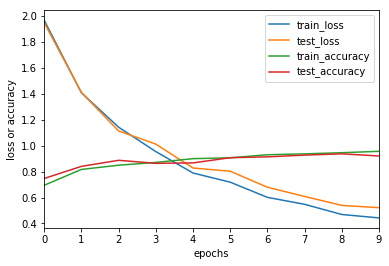

In [8]:
# lossのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
print(df_log)
df_log.plot()
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

In [9]:
#間違った画像を表示
#snet.display_miss_img(X_test, y_test)

## 学習済みモデルの出力

In [10]:
#with open("katakana_model.pickle", "wb") as f:
#    pickle.dump(snet, f)

In [11]:

#print(snet.params['W1'])



#W1~4, b1~4を抽出
for idx in range(1, 5):
    with open("model_params\katakana_model_W" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['W' + str(idx)], f)
    with open("model_params\katakana_model_b" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['b' + str(idx)], f)

#バッチ正規化レイヤのパラメータを抽出
with open("model_params\katakana_model_gamma1.pickle", "wb") as f:
    pickle.dump(snet.params['gamma1'], f)
with open("model_params\katakana_model_beta1.pickle", "wb") as f:
    pickle.dump(snet.params['beta1'], f)
with open("model_params\katakana_model_moving_mean.pickle", "wb") as f:
    pickle.dump(snet.layers['BatchNorm1'].moving_mean, f)
with open("model_params\katakana_model_moving_var.pickle", "wb") as f:
    pickle.dump(snet.layers['BatchNorm1'].moving_var, f)


    

#print("snet.params['beta1']", snet.params['beta1'])
#print("snet.params['gamma1']", snet.params['gamma1'])
#print(snet.layers['BatchNorm1'].moving_mean)
#print(snet.layers['BatchNorm1'].moving_var)

snet.params['beta1'] [ 0.09031114  0.05185595  0.07033049  0.09602429  0.06537135  0.0733259
  0.0113774   0.10161191 -0.00367888  0.11902494  0.05190215  0.02374744
  0.06763506  0.00547109  0.06790329  0.03600049]
snet.params['gamma1'] [1.22100424 1.23638926 1.21292512 1.2255872  1.19630582 1.19637444
 1.2243542  1.18993873 1.23070149 1.21072196 1.22379766 1.22649109
 1.1050332  1.19516032 1.10493302 1.14125639]
[-0.01235532 -0.00208604 -0.00306045 -0.01099033 -0.00476052 -0.00609277
 -0.00266093 -0.01422595  0.00024204 -0.02558796 -0.00287063 -0.0024922
  0.037462   -0.00057631  0.03573264  0.01048576]
[0.00040576 0.00023408 0.00026238 0.00022767 0.00026304 0.00028108
 0.00030062 0.00026118 0.00037108 0.00041358 0.00032873 0.00035542
 0.00014123 0.00019586 0.00015469 0.00022274]
